In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load training masks from CSV
train_masks = pd.read_csv("/kaggle/input/deep-vision-showdown-procom-25/train.csv")

import os

# Load images and masks
def load_data(image_dir, mask_csv):
    images = []
    masks = []
    for idx, row in mask_csv.iterrows():
        img_path = os.path.join(image_dir, f"{row['image_id']}.tif")
        mask_rle = row['pixels']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale
        mask = rle_to_mask(mask_rle, image.shape)  # Convert RLE to mask
        # if mask.shape != image.shape:
        #     print(f"Failed to fix mask shape for image: {img_path}")
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)
                

# Convert RLE to mask
def rle_to_mask(rle, shape):
    if pd.isna(rle) or not rle:  # Handle empty masks
        return np.zeros(shape, dtype=np.uint8)
    
    height, width = shape  # Unpack the mask dimensions
    mask = np.zeros(height * width, dtype=np.uint8)  # Flattened mask
    
    s = list(map(int, rle.split()))
    starts, lengths = s[0::2], s[1::2]  # Extract start positions and lengths
    
    for start, length in zip(starts, lengths):
        start -= 1  # Convert to zero-based index
        mask[start:start + length] = 1  # Fill the mask with 1s in the given range

    return mask.reshape((width, height)).T  # Convert to row-major format


In [2]:
import albumentations as A

aug = A.Compose([
    A.Resize(448, 608),
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Simulate tissue deformation
    A.GaussianBlur(p=0.3),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(max_holes=10, max_height=20, max_width=20, p=0.2),  # Simulate artifacts
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=99b0c472942241c23d7b32d9b0ee2ca6d651aa5ff6136ac5ebcd0c1f49be2589
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a00bc1d09bb9f9b830371c2202a43bcb9112e936eedb8fdd5514474cd43bb500
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",  # Pretrained on ImageNet
    encoder_weights="imagenet",
    in_channels=1,            # Grayscale images
    classes=1,                # Binary segmentation
    activation="sigmoid",     # Output probabilities
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s] 


In [5]:
import torch
import segmentation_models_pytorch as smp

dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=False)
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    return 0.5 * dice_loss(y_pred, y_true) + 0.5 * bce_loss(y_pred, y_true)

In [6]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

class MedicalDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        # print('image shape', image.shape)
        # print('mask shape:', mask.shape)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

In [7]:
from torch.utils.data import random_split

# Load data
images, masks = load_data("/kaggle/input/deep-vision-showdown-procom-25/train_set", train_masks)
dataset = MedicalDataset(images, masks, transform=aug)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

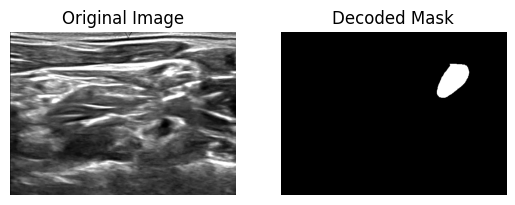

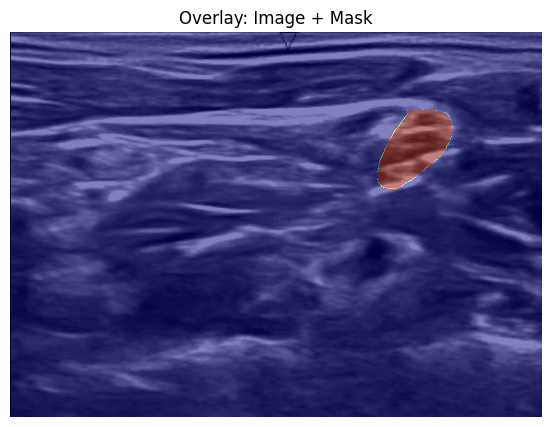

In [21]:
image_dir = '/kaggle/input/deep-vision-showdown-procom-25/train_set'
# Select the first row for debugging
row = train_masks.iloc[0]
img_path = os.path.join(image_dir, f"{row['image_id']}.tif")

# Read the image (grayscale)
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Convert RLE to mask
mask = rle_to_mask(row['pixels'], image.shape)

# Show image and mask
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Decoded Mask")
plt.axis("off")

plt.show()
plt.figure(figsize=(10, 5))

# Show the original image
plt.imshow(image, cmap="gray")
plt.imshow(mask, cmap="jet", alpha=0.5)  # Overlay mask with color and transparency

plt.title("Overlay: Image + Mask")
plt.axis("off")
plt.show()


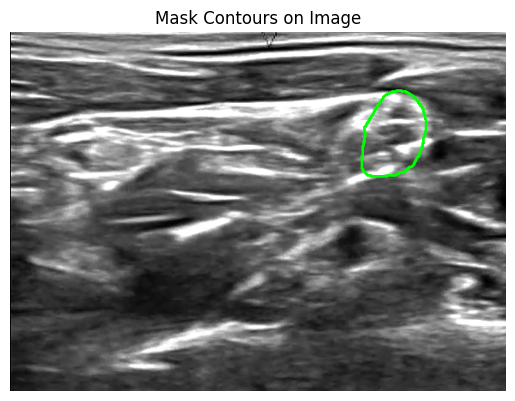

In [9]:
import cv2
import numpy as np

# Find contours in the mask
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert image to color (for better contrast)
image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw contours on the original image
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Green contours

# Show result
plt.imshow(image_with_contours)
plt.title("Mask Contours on Image")
plt.axis("off")
plt.show()


In [10]:
device =  torch.device("cuda")
print(f'Using device: {device}')
model = model.to(device)

Using device: cuda


In [11]:
from tqdm import tqdm
# Optimizer with Weight Decay (L2 Regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning Rate Scheduler (Reduce LR if Validation Loss Stops Improving)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Directory to save checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_loss = float('inf')
early_stopping_patience = 10  # Stop training if val loss doesn't improve for 10 epochs
no_improve_epochs = 0  # Counter for early stopping
latest_model_path = os.path.join(checkpoint_dir, 'latest_model.pth')
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

for epoch in range(100):
    model.train()
    running_loss = 0.0
    
    # Training loop with Gradient Clipping
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        
        # Backpropagation with Gradient Clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate training loss
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()
    
    # Calculate validation loss
    val_loss /= len(val_loader)
    print(f"Epoch {epoch}: Validation Loss = {val_loss:.4f}")
    
    # Adjust Learning Rate based on Validation Loss
    scheduler.step(val_loss)
    
    # Save the latest model
    torch.save(model.state_dict(), latest_model_path)
    
    # Save best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with validation loss: {best_loss:.4f}")
        no_improve_epochs = 0  # Reset early stopping counter
    else:
        no_improve_epochs += 1  # Increase counter if no improvement
        print(f"⚠️ No improvement for {no_improve_epochs}/{early_stopping_patience} epochs.")

    # Early Stopping: Stop training if no improvement for 'early_stopping_patience' epochs
    if no_improve_epochs >= early_stopping_patience:
        print("⏹️ Early stopping triggered. Training stopped.")
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 99/99 [01:46<00:00,  1.07s/it]


Epoch 0: Train Loss = 0.9106
Epoch 0: Validation Loss = 0.8703
✅ Best model saved with validation loss: 0.8703


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 1: Train Loss = 0.8513
Epoch 1: Validation Loss = 0.8267
✅ Best model saved with validation loss: 0.8267


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 2: Train Loss = 0.8084
Epoch 2: Validation Loss = 0.7858
✅ Best model saved with validation loss: 0.7858


100%|██████████| 99/99 [01:46<00:00,  1.07s/it]


Epoch 3: Train Loss = 0.7627
Epoch 3: Validation Loss = 0.7406
✅ Best model saved with validation loss: 0.7406


100%|██████████| 99/99 [01:47<00:00,  1.08s/it]


Epoch 4: Train Loss = 0.7099
Epoch 4: Validation Loss = 0.6871
✅ Best model saved with validation loss: 0.6871


100%|██████████| 99/99 [01:47<00:00,  1.08s/it]


Epoch 5: Train Loss = 0.6543
Epoch 5: Validation Loss = 0.6414
✅ Best model saved with validation loss: 0.6414


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 6: Train Loss = 0.6036
Epoch 6: Validation Loss = 0.6035
✅ Best model saved with validation loss: 0.6035


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 7: Train Loss = 0.5689
Epoch 7: Validation Loss = 0.5982
✅ Best model saved with validation loss: 0.5982


100%|██████████| 99/99 [01:46<00:00,  1.07s/it]


Epoch 8: Train Loss = 0.5461
Epoch 8: Validation Loss = 0.5845
✅ Best model saved with validation loss: 0.5845


100%|██████████| 99/99 [01:46<00:00,  1.08s/it]


Epoch 9: Train Loss = 0.5191
Epoch 9: Validation Loss = 0.5688
✅ Best model saved with validation loss: 0.5688


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 10: Train Loss = 0.5060
Epoch 10: Validation Loss = 0.5915
⚠️ No improvement for 1/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 11: Train Loss = 0.4946
Epoch 11: Validation Loss = 0.5630
✅ Best model saved with validation loss: 0.5630


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 12: Train Loss = 0.4869
Epoch 12: Validation Loss = 0.5561
✅ Best model saved with validation loss: 0.5561


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 13: Train Loss = 0.4802
Epoch 13: Validation Loss = 0.5710
⚠️ No improvement for 1/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 14: Train Loss = 0.4728
Epoch 14: Validation Loss = 0.5715
⚠️ No improvement for 2/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 15: Train Loss = 0.4671
Epoch 15: Validation Loss = 0.5654
⚠️ No improvement for 3/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 16: Train Loss = 0.4629
Epoch 16: Validation Loss = 0.5623
⚠️ No improvement for 4/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 17: Train Loss = 0.4636
Epoch 17: Validation Loss = 0.5725
⚠️ No improvement for 5/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 18: Train Loss = 0.4554
Epoch 18: Validation Loss = 0.5849
⚠️ No improvement for 6/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 19: Train Loss = 0.4457
Epoch 19: Validation Loss = 0.5630
⚠️ No improvement for 7/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 20: Train Loss = 0.4436
Epoch 20: Validation Loss = 0.5550
✅ Best model saved with validation loss: 0.5550


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 21: Train Loss = 0.4359
Epoch 21: Validation Loss = 0.5640
⚠️ No improvement for 1/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 22: Train Loss = 0.4321
Epoch 22: Validation Loss = 0.5658
⚠️ No improvement for 2/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 23: Train Loss = 0.4294
Epoch 23: Validation Loss = 0.5640
⚠️ No improvement for 3/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 24: Train Loss = 0.4294
Epoch 24: Validation Loss = 0.5654
⚠️ No improvement for 4/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 25: Train Loss = 0.4248
Epoch 25: Validation Loss = 0.5671
⚠️ No improvement for 5/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Epoch 26: Train Loss = 0.4227
Epoch 26: Validation Loss = 0.5598
⚠️ No improvement for 6/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 27: Train Loss = 0.4191
Epoch 27: Validation Loss = 0.5647
⚠️ No improvement for 7/10 epochs.


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Epoch 28: Train Loss = 0.4173
Epoch 28: Validation Loss = 0.5623
⚠️ No improvement for 8/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 29: Train Loss = 0.4159
Epoch 29: Validation Loss = 0.5720
⚠️ No improvement for 9/10 epochs.


100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Epoch 30: Train Loss = 0.4157
Epoch 30: Validation Loss = 0.5716
⚠️ No improvement for 10/10 epochs.
⏹️ Early stopping triggered. Training stopped.


In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import segmentation_models_pytorch as smp

def mask_to_rle(mask):
    """
    Convert mask to RLE string in **column-major** order (competition requirement).
    """
    # Transpose to width-first order (column-major)
    mask = mask.T  # (W, H)
    
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])  # Add boundary zeros
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]  # Calculate run lengths
    
    return ' '.join(str(x) for x in runs) if len(runs) > 0 else ''

def predict_and_save(test_dir, model_path, submission_path):
    # Load model
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=1,
        classes=1,
        activation="sigmoid"
    )
    model.load_state_dict(torch.load(model_path))
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Predict on test images
    test_images = sorted(os.listdir(test_dir))
    results = []

    for img_name in test_images:
        if not img_name.endswith(".tif"):
            continue

        # Load image and get original dimensions
        img_path = os.path.join(test_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        original_h, original_w = image.shape  # (H, W)

        # Resize to model input size (448x608)
        image_resized = cv2.resize(image, (608, 448), interpolation=cv2.INTER_LINEAR)  # (W, H)
        image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            pred = model(image_tensor)
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)  # (448, 608)

        # Resize mask back to original dimensions
        resized_mask = cv2.resize(pred_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)  # (W, H)

        # Convert to RLE
        rle = mask_to_rle(resized_mask)
        results.append({'img': img_name.replace('.tif', ''), 'pixels': rle})

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(submission_path, index=False)

predict_and_save(
    test_dir="/kaggle/input/deep-vision-showdown-procom-25/test_set",
    model_path="/kaggle/working/checkpoints/best_model.pth",
    submission_path="submission.csv"
)

<ipython-input-28-d7aa74f11d61>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<ipython-input-30-2996d714459d>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/checkpoints/best_model.pth"))


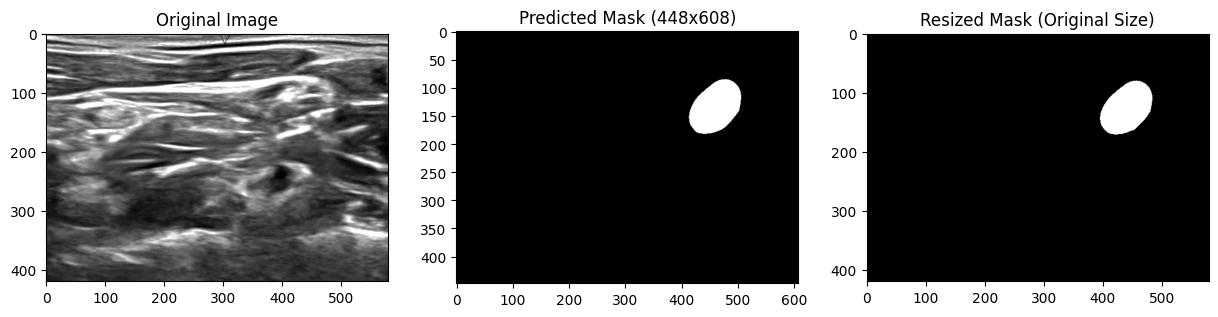

In [30]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Load model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
    activation="sigmoid"
)
model.load_state_dict(torch.load("/kaggle/working/checkpoints/best_model.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and preprocess a single image
def load_and_preprocess(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    original_h, original_w = image.shape  # Original dimensions
    image_resized = cv2.resize(image, (608, 448), interpolation=cv2.INTER_LINEAR)  # Resize to model input size
    image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    return image, image_tensor, (original_h, original_w)

# Predict mask
def predict_mask(model, image_tensor):
    with torch.no_grad():
        pred = model(image_tensor)
    pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)  # Binary mask
    return pred_mask

# Resize mask to original dimensions
def resize_mask(pred_mask, original_h, original_w):
    return cv2.resize(pred_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

# Visualize image and masks
def visualize(image, pred_mask, resized_mask):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")

    # Predicted Mask (Resized to Model Input Size)
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask (448x608)")
    plt.imshow(pred_mask, cmap="gray")

    # Resized Mask (Original Dimensions)
    plt.subplot(1, 3, 3)
    plt.title("Resized Mask (Original Size)")
    plt.imshow(resized_mask, cmap="gray")

    plt.show()

# Test on a single image
image_path = "/kaggle/input/deep-vision-showdown-procom-25/train_set/8c65e96b19.tif"  # Replace with your image path
image, image_tensor, (original_h, original_w) = load_and_preprocess(image_path)
pred_mask = predict_mask(model, image_tensor)
resized_mask = resize_mask(pred_mask, original_h, original_w)

# Visualize
visualize(image, pred_mask, resized_mask)

In [31]:
import torch
import numpy as np

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    """
    Compute Dice coefficient for binary segmentation masks.
    
    Args:
        y_pred (torch.Tensor): Predicted mask (B, H, W).
        y_true (torch.Tensor): Ground truth mask (B, H, W).
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        float: Dice coefficient.
    """
    # Flatten tensors
    y_pred_flat = y_pred.view(-1)  # Flatten to 1D
    y_true_flat = y_true.view(-1)  # Flatten to 1D
    
    # Compute intersection and sums
    intersection = (y_pred_flat * y_true_flat).sum()
    pred_sum = y_pred_flat.sum()
    true_sum = y_true_flat.sum()
    
    # Compute Dice
    dice = (2. * intersection + smooth) / (pred_sum + true_sum + smooth)
    return dice.item()

def evaluate_dice(data_loader, model, device):
    """
    Evaluate Dice coefficient for a data loader.
    
    Args:
        data_loader (DataLoader): Data loader for validation/test set.
        model (torch.nn.Module): Trained segmentation model.
        device (torch.device): Device to run evaluation on (e.g., "cuda" or "cpu").
    
    Returns:
        float: Mean Dice coefficient over the entire data loader.
    """
    model.eval()  # Set model to evaluation mode
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Predict
            outputs = model(images)
            pred_masks = (outputs.sigmoid() > 0.5).float()  # Binary masks
            
            # Compute Dice for the batch
            batch_dice = dice_coefficient(pred_masks, masks)
            total_dice += batch_dice * images.size(0)  # Weighted sum
            num_samples += images.size(0)  # Total samples

    # Compute mean Dice
    mean_dice = total_dice / num_samples
    return mean_dice